# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
import time

import warnings
warnings.filterwarnings('ignore')
from workspace_utils import active_session

from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

#### Read Stored DataFrames ####
- [Read final merged DF to then perform clustering](#df_merge_final)
- [Read final customers data to then perform clustering](#df_cust)

In [3]:
# load in the data (takes a while)
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.shape

(891221, 366)

In [4]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
feat_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])

In [7]:
feat_info.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [8]:
feat_info.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
feat_info.shape

(313, 4)

In [10]:
feat_info = feat_info[~feat_info['Attribute'].isnull()]

In [11]:
feat_info.shape

(313, 4)

In [12]:
feat_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=[0])
feat_values.drop('Unnamed: 0', axis=1, inplace=True)

In [13]:
feat_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [14]:
feat_values.shape

(2258, 4)

In [15]:
feat_values['Attribute'] = feat_values['Attribute'].fillna(method='ffill')
feat_values['Description'] = feat_values['Description'].fillna(method='ffill')

In [16]:
feat_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [26]:
#features and their missing values info from previous project
feat_info_prev = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [18]:
feat_info_prev.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [19]:
feat_info_prev.shape

(85, 4)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Step 1: Preprocessing

#### Step 1.1: Clean a part of the dataset with previous work
Part of the dataset was cleaned in the previous project. Given the size of the dataset split into two and then merge them once cleaned. 

In [20]:
cols_prev = [col for col in azdias.columns if col in list(feat_info_prev['attribute'])]
cols_new = [col for col in azdias.columns if col not in list(feat_info_prev['attribute'])]

In [21]:
df_new = azdias[cols_new].copy()

In [22]:
df_prev = azdias[cols_prev].copy()

In [23]:
print(df_prev.shape, df_new.shape)

(891221, 85) (891221, 281)


In [27]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    #CHECK
    if df.shape[1]!=85:
        print('Attention,' 
              'number of columns different than original initial dataframe. Cleaning process might be wrong.')
    
    #PREPROCESSING
    
    #transform in array
    feat_info_prev['values'] = feat_info_prev.missing_or_unknown.apply(lambda x: x[1:-1].split(',') )
    
    
    #transform missing or unknown to NaN
    for column in df:
        index = feat_info_prev.index[feat_info_prev['attribute']==column].tolist()[0]
        m = df[column].isin(feat_info_prev['values'][index])
        df[column] = df[column].mask(m, np.nan)
     
    
    #REMOVING COLUMNS AND ROWS    
    
    #removing columns where more than 50% of the data is missing
    df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR', 'ALTER_HH'],axis=1,inplace=True)
    
    #removing rows with more than 50% of the data missing
    #df = df[np.sum(df.isnull(), axis=1) < 31]
    
    
    #RE-ENCODING FEATURES
    
    #categorical features: remove FEIN columns as we have rough scale and remove CAMEO_DEU_2015 as there are 
    #too many non-numeric categories
    df.drop(['CAMEO_DEU_2015','LP_STATUS_FEIN', 'LP_FAMILIE_FEIN'], axis=1, inplace=True)
    
    #Re-encode OST_WEST_KZ
    df['OST_WEST_KZ'].replace('W', 0, inplace=True)
    df['OST_WEST_KZ'].replace('O', 1, inplace=True)
    
    #mixed features: remove the two below as they have too many categories
    df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis =1, inplace=True)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables
    df['Mainstream'] = 0 #default value
    m_main = df['PRAEGENDE_JUGENDJAHRE'].isin([2.0,4.0,6.0,7.0,9.0,11.0,13.0,15.0]) #avantgarde
    df['Mainstream'] = df['Mainstream'].where(m_main, 1)
    
    decade_dictionary ={1 : 40, 2 : 40, 3 : 50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13: 80, 
                        14:90, 15:90} 
    df['Decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dictionary) 
    
    #Investigate "CAMEO_INTL_2015" and engineer two new variables.
    def cameo_wealth(x):
        if pd.isnull(x):
            return np.nan
        elif 'X' in str(x) or 'x' in str(x):
            return np.nan
        else:
            return int(str(x)[0])

    def cameo_life(x):
        if pd.isnull(x):
            return np.nan
        elif 'X' in str(x) or 'x' in str(x):
            return np.nan
        else:
            return int(str(x)[1])
    
    df['Wealth'] = df['CAMEO_INTL_2015'].apply(cameo_wealth)
    df['LifeStage'] = df['CAMEO_INTL_2015'].apply(cameo_life)
    
    #Drop PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1, inplace=True)

    #Finally drop the columns below as they have too many missing values and categories
    df.drop(['WOHNLAGE','PLZ8_BAUMAX','CAMEO_DEUG_2015'], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df

In [25]:
df_prev_clean = clean_data(df_prev)

In [26]:
df_prev_clean.shape

(891221, 73)

#### Step 1.2: Clean new part of the dataset

In [29]:
df_new.head()

,LNR,AKT_DAT_KL,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,CJT_KATALOGNUTZER,...,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,910220,9.0,NaN,NaN,NaN,NaN,21.0,0.0,12.0,1.0,...,2.0,3.0,3.0,1.0,0.0,0.0,4.0,8.0,11.0,10.0
2,910225,9.0,NaN,NaN,NaN,NaN,17.0,0.0,7.0,2.0,...,3.0,2.0,5.0,0.0,1.0,0.0,2.0,9.0,9.0,6.0
3,910226,1.0,NaN,NaN,NaN,NaN,13.0,0.0,2.0,3.0,...,1.0,4.0,5.0,0.0,0.0,1.0,0.0,7.0,10.0,11.0
4,910241,1.0,NaN,NaN,NaN,NaN,14.0,0.0,3.0,3.0,...,3.0,4.0,3.0,0.0,1.0,0.0,2.0,3.0,5.0,4.0


In [31]:
feat_values['Meaning'].fillna('unknown', inplace=True)

In [32]:
feat_values_missing = feat_values[feat_values['Meaning'].str.contains("unknown")] 

In [34]:
feat_values_missing.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [35]:
#transform in array
feat_values_missing['values'] = feat_values_missing.Value.apply(lambda x: str(x).split(',') )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
#transform missing or unknown to NaN
for column in df_new:
    try:
        index = feat_values_missing.index[feat_values_missing['Attribute']==column].tolist()[0]
        m = df_new[column].isin(feat_values_missing['values'][index])
        df_new[column] = df_new[column].mask(m, np.nan)
    except:
        continue

In [38]:
#proportion of missing values per column
tot = len(df_new)
null_counts = df_new.isnull().sum()/tot
null_counts.sort_values(ascending=False, inplace=True)
null_counts.head(20)

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
ALTERSKATEGORIE_FEIN           0.295041
D19_VERSAND_ONLINE_QUOTE_12    0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_KONSUMTYP                  0.288495
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_SOZIALES                   0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
KBA05_AUTOQUOT                 0.166193
KBA05_SEG1                     0.166188
KBA05_MOTOR                    0.166188
KBA05_MOD8                     0.166188
KBA05_MOD4                     0.166188
dtype: float64

In [40]:
#remove columns with more than 20% of data missing
df_new.drop(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992', 'ALTERSKATEGORIE_FEIN',
            'D19_VERSAND_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12', 
            'D19_TELKO_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
            'D19_VERSI_ONLINE_QUOTE_12'], axis=1, inplace=True)

In [41]:
#export_new_csv = df_new.to_csv(r'export_new.csv', index = None, header=True) 

In [42]:
df_merge = pd.concat([df_new, df_prev_clean], axis = 1)

In [45]:
df_merge.shape

(891221, 339)

In [46]:
tot_cols = df_merge.shape[1]

In [49]:
null_row = pd.DataFrame(np.sum(df_merge.isnull(), axis=1))

In [51]:
null_row.head()

,0
0,235
1,0
2,0
3,5
4,0


In [53]:
null_row = null_row.sort_values(by=0, ascending=False)

In [54]:
null_row = null_row/tot_cols

In [60]:
null_row.shape

(891221, 1)

In [65]:
null_row[null_row[0]>0.5].shape

(99977, 1)

In [67]:
null_row[null_row[0]>0.2].shape

(115585, 1)

In [68]:
#drop rows with more than 20% values missing
df_merge_clean = df_merge[np.sum(df_merge.isnull(), axis=1) <= 0.2]

In [71]:
df_merge_clean.shape

(611724, 339)

In [74]:
#proportion of missing values per column - do it again now that we have smaller set
tot = len(df_merge_clean)
null_counts = df_merge_clean.isnull().sum()/tot
null_counts.sort_values(ascending=False, inplace=True)
null_counts.head(20)

LifeStage         0
KBA05_MODTEMP     0
KBA05_MAXHERST    0
KBA05_MAXSEG      0
KBA05_MAXVORB     0
KBA05_MOD1        0
KBA05_MOD2        0
KBA05_MOD3        0
KBA05_MOD4        0
KBA05_MOD8        0
KBA05_MOTOR       0
KBA05_CCM3        0
KBA05_MOTRAD      0
KBA05_SEG1        0
KBA05_SEG10       0
KBA05_SEG2        0
KBA05_SEG3        0
KBA05_SEG4        0
KBA05_SEG5        0
KBA05_SEG6        0
dtype: int64

In [82]:
df_merge_clean.isnull().sum().sum() #no nulls

0

### Step 1.2: Select and Re-Encode Features
Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. 

In [89]:
df_merge_clean.select_dtypes(include='object') #only one string, all the others are numerical variables

,EINGEFUEGT_AM
0,1992-02-10 00:00:00
1,1992-02-12 00:00:00
2,1992-02-12 00:00:00
3,1992-02-12 00:00:00
4,1992-02-12 00:00:00
5,1992-02-10 00:00:00
6,1992-02-10 00:00:00
7,1992-02-10 00:00:00
8,1992-02-10 00:00:00
9,1992-02-12 00:00:00


In [101]:
feat_values[feat_values.Attribute=='EINGEFUEGT_AM'] #not in reference file so drop as we don't know the meaning anyway

,Attribute,Description,Value,Meaning


In [102]:
df_merge_clean.drop('EINGEFUEGT_AM',axis=1,inplace=True)

In [ ]:
#drop LNR as it is ID
df_merge_clean.drop('LNR',axis=1,inplace=True)

In [ ]:
export_merge_final_csv = df_merge_clean.to_csv(r'export_merge_final.csv', index = None, header=True)

<a id='df_merge_final'></a>
#### Read final merge dataset ####

In [110]:
df_merge_final = pd.read_csv('export_merge_final.csv')

### Summary of Data Preprocessing Steps
Due to the large size of the dataset and the work previously done on some of the features, I have decided to split it into two, one with the features I worked with in the previous project and one with the new features. 
- Clean the dataset with the features seen in the past in the same manner as in term 1 (without removing any rows though)
- Replace with NA some of the values in the new dataset according to the excel provided 
- Remove columns with more than 20% missing values
- Merge the two datasets 
- Remove rows with more than 20% of missing values (this step will not be performed on the customers and mailout data as we want to keep all the rows there)
- Check that all column types are numeric --> only one found not to be so remove it
- Remove `LNR` as it is an ID column

### Step 2: Feature Transformation

#### Step 2.1: Apply Feature Scaling

In [112]:
features = df_merge_final.copy()

In [113]:
#scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [114]:
scaled_features

array([[ 1.26224131, -0.29901685,  0.34129589, ...,  1.16559045,
         1.15889695, -1.26055757],
       [ 1.26224131, -0.29901685, -0.03049263, ...,  1.16559045,
        -0.89878144,  0.74640892],
       [-0.93931419, -0.29901685, -0.32792345, ..., -0.21431049,
         0.47300415,  0.07742009],
       ..., 
       [ 1.26224131, -0.29901685,  0.11822278, ...,  0.47563998,
        -0.21288864, -1.26055757],
       [ 1.26224131,  1.74199834, -0.17920804, ...,  1.16559045,
         1.15889695, -1.26055757],
       [-0.93931419, -0.29901685, -0.17920804, ..., -1.59421143,
         0.47300415,  0.07742009]])

#### Step 2.2: Perform Dimensionality Reduction
Now that we have scaled data we can apply dimensionality reduction methods. From term 1 project:
- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [6]:
# Apply PCA to the data.
pca = PCA()
pca_features = pca.fit_transform(scaled_features)

In [7]:
pca_features.shape

(611724, 338)

In [10]:
# Investigate the variance accounted for by each principal component.

#Function from Udacity lectures
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


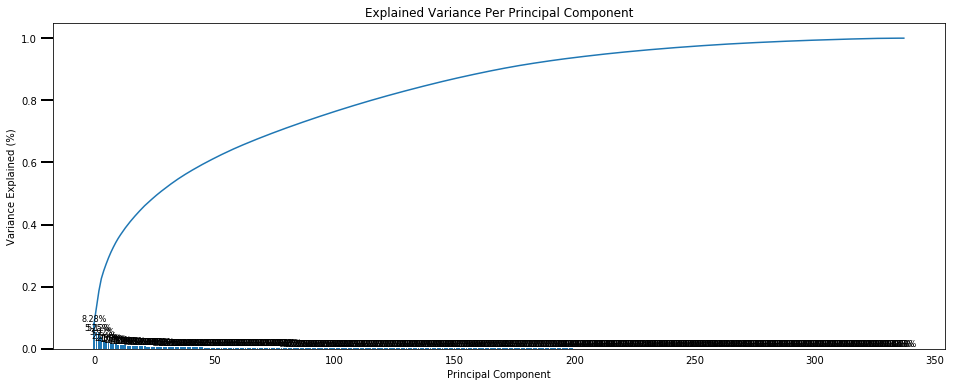

In [9]:
scree_plot(pca)

In [115]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 100)
pca_features = pca.fit_transform(scaled_features)

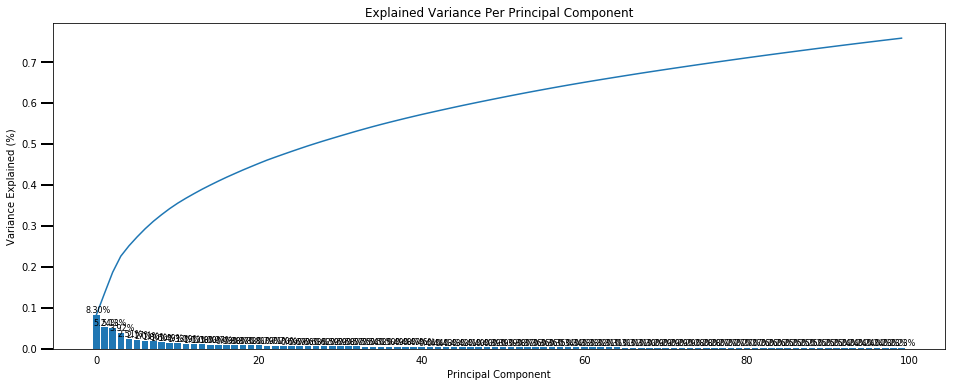

In [116]:
scree_plot(pca)

In [117]:
sum(pca.explained_variance_ratio_)

0.75801714931353603

### Summary of Feature Transformation
- Check if there are any missing values. Here there are not but if there are (as for the customers and mailout datasets) use an imputer (later I use an imputer with median)
- Scale the features using StandardScaler
- Run PCA on the scaled features selecting 100 components

### Step 3: Clustering

#### Step 3.1: Apply Clustering to General Population
From project in term 1:

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [14]:
#from project in term 1 - split because it takes long

scores_2 = []
start = time.time()

# Over a number of different cluster counts...

with active_session():
    for center in list(range(31,61)):
        print('\nNumber of Centroids: {}.\n'.format(center))

        # run k-means clustering on the data and...
        kmeans = KMeans(n_clusters=center)
        model = kmeans.fit(pca_features)
        print('Model created.\n')

        # compute the average within-cluster distances.
        score = np.abs(model.score(pca_features))
        scores_2.append(score)

        print('Number of Centroids: {}, score: {}.\n'.format(center, round(score,2)))

end = time.time()
print(end-start)


Number of Centroids: 31.

Model created.

Number of Centroids: 31, score: 113062905.13.


Number of Centroids: 32.

Model created.

Number of Centroids: 32, score: 112880104.92.


Number of Centroids: 33.

Model created.

Number of Centroids: 33, score: 112601269.82.


Number of Centroids: 34.

Model created.

Number of Centroids: 34, score: 112383203.47.


Number of Centroids: 35.

Model created.

Number of Centroids: 35, score: 112129568.31.


Number of Centroids: 36.

Model created.

Number of Centroids: 36, score: 111870360.92.


Number of Centroids: 37.

Model created.

Number of Centroids: 37, score: 111638890.87.


Number of Centroids: 38.

Model created.

Number of Centroids: 38, score: 111412776.99.


Number of Centroids: 39.

Model created.

Number of Centroids: 39, score: 111222266.84.


Number of Centroids: 40.

Model created.

Number of Centroids: 40, score: 110920793.46.


Number of Centroids: 41.

Model created.

Number of Centroids: 41, score: 110794573.05.


Number of

KeyboardInterrupt: 

In [15]:
scores_2

[113062905.13378751,
 112880104.91542308,
 112601269.82028483,
 112383203.46733704,
 112129568.31271562,
 111870360.92296298,
 111638890.86862686,
 111412776.99273033,
 111222266.83883438,
 110920793.46230903,
 110794573.05427824,
 110611028.80288351,
 110335172.65119207,
 110259770.91692562,
 109862469.51025552,
 109724514.42568073,
 109532815.1458234,
 109432565.69928868,
 109356999.72192512,
 109194441.36488727]

In [26]:
scores_1

[156575292.9611049,
 144264939.24133757,
 138857664.02716103,
 134950177.66776907,
 131886514.07921354,
 129404485.89735673,
 127279005.52156579,
 125831542.64834192,
 124443530.96744902,
 123345942.64442833,
 122447438.32215467,
 121648817.13802862,
 120886660.54167809,
 120214306.12515964,
 119556802.74843439,
 118913901.24084842,
 118413062.23693906,
 117854358.71507031,
 117398256.54124942,
 116959740.97370391,
 116524474.89661671,
 116135598.79830062,
 115675058.23941886,
 115315245.13186787,
 114948440.31159708,
 114648656.98897444,
 114295020.55057105,
 113999519.15820149,
 113590383.46247552,
 113396007.33177671]

In [1]:
scores_1 = [156575292.9611049,
 144264939.24133757,
 138857664.02716103,
 134950177.66776907,
 131886514.07921354,
 129404485.89735673,
 127279005.52156579,
 125831542.64834192,
 124443530.96744902,
 123345942.64442833,
 122447438.32215467,
 121648817.13802862,
 120886660.54167809,
 120214306.12515964,
 119556802.74843439,
 118913901.24084842,
 118413062.23693906,
 117854358.71507031,
 117398256.54124942,
 116959740.97370391,
 116524474.89661671,
 116135598.79830062,
 115675058.23941886,
 115315245.13186787,
 114948440.31159708,
 114648656.98897444,
 114295020.55057105,
 113999519.15820149,
 113590383.46247552,
 113396007.33177671]

In [16]:
scores_2 = [113062905.13378751,
 112880104.91542308,
 112601269.82028483,
 112383203.46733704,
 112129568.31271562,
 111870360.92296298,
 111638890.86862686,
 111412776.99273033,
 111222266.83883438,
 110920793.46230903,
 110794573.05427824,
 110611028.80288351,
 110335172.65119207,
 110259770.91692562,
 109862469.51025552,
 109724514.42568073,
 109532815.1458234,
 109432565.69928868,
 109356999.72192512,
 109194441.36488727]

In [17]:
final_scores = scores_1 + scores_2

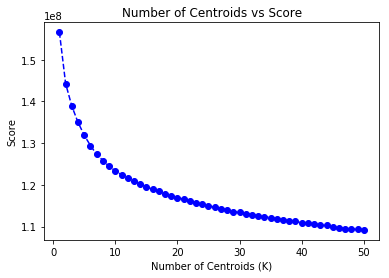

In [19]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(list(range(1,51)), final_scores, linestyle='--', marker = 'o', color = 'b')
plt.xlabel('Number of Centroids (K)')
plt.ylabel('Score')
plt.title('Number of Centroids vs Score');

In [118]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

clusters = 15 #we can see that from 15 clusters onwards the error decreases at a much slower rate

kmeans = KMeans(n_clusters=clusters) 
model = kmeans.fit(pca_features)
labels = model.predict(pca_features)


### Step 3.2: Apply All Steps to the Customer Data

(from Udacity project term 1)

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [21]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [22]:
customers.shape

(191652, 369)

In [23]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [119]:
def clean_data_all(df):
    #split
    feat_info_prev = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    cols_prev = [col for col in df.columns if col in list(feat_info_prev['attribute'])]
    cols_new = [col for col in df.columns if col not in list(feat_info_prev['attribute'])]
    
    df_new = df[cols_new].copy()
    df_prev = df[cols_prev].copy()
    
    #previous features
    df_prev_clean = clean_data(df_prev)
    
    #new features
    feat_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=[0])
    feat_values.drop('Unnamed: 0', axis=1, inplace=True)

    feat_values['Attribute'] = feat_values['Attribute'].fillna(method='ffill')
    feat_values['Description'] = feat_values['Description'].fillna(method='ffill')

    feat_values['Meaning'].fillna('unknown', inplace=True)
    feat_values_missing = feat_values[feat_values['Meaning'].str.contains("unknown")] 

    #transform in array
    feat_values_missing['values'] = feat_values_missing.Value.apply(lambda x: str(x).split(',') )

    #transform missing or unknown to NaN
    for column in df_new:
        try:
            index = feat_values_missing.index[feat_values_missing['Attribute']==column].tolist()[0]
            m = df_new[column].isin(feat_values_missing['values'][index])
            df_new[column] = df_new[column].mask(m, np.nan)
        except:
            continue
    
    df_new.drop(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992', 'ALTERSKATEGORIE_FEIN',
            'D19_VERSAND_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12', 
            'D19_TELKO_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
            'D19_VERSI_ONLINE_QUOTE_12','EINGEFUEGT_AM', 'LNR'], axis=1, inplace=True)
    
    if df_new.shape[1] ==267:
        df_new.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)
        
    #concat
    df_merged = pd.concat([df_new, df_prev_clean], axis = 1)  
    
    #check for missing columns
    missing = list(np.setdiff1d(features.columns, df_merged.columns))
    if len(missing) !=0:
        print('Attention, not same number of columns as expected!')
        print(missing)
        
    return df_merged

In [120]:
df_cust_clean = clean_data_all(customers)

In [121]:
df_cust_clean.shape

(191652, 337)

In [122]:
export_final_cust_csv = df_cust_clean.to_csv(r'df_final_cust.csv', index = None, header=True) 

In [123]:
df_cust_clean.isnull().sum()

AKT_DAT_KL                    46596
ANZ_KINDER                    46596
ANZ_STATISTISCHE_HAUSHALTE    49927
CJT_KATALOGNUTZER              3213
CJT_TYP_1                      3213
CJT_TYP_2                      3213
CJT_TYP_3                      3213
CJT_TYP_4                      3213
CJT_TYP_5                      3213
CJT_TYP_6                      3213
D19_BANKEN_ANZ_12                 0
D19_BANKEN_ANZ_24                 0
D19_BANKEN_DATUM                  0
D19_BANKEN_DIREKT                 0
D19_BANKEN_GROSS                  0
D19_BANKEN_LOKAL                  0
D19_BANKEN_OFFLINE_DATUM          0
D19_BANKEN_ONLINE_DATUM           0
D19_BANKEN_REST                   0
D19_BEKLEIDUNG_GEH                0
D19_BEKLEIDUNG_REST               0
D19_BILDUNG                       0
D19_BIO_OEKO                      0
D19_BUCH_CD                       0
D19_DIGIT_SERV                    0
D19_DROGERIEARTIKEL               0
D19_ENERGIE                       0
D19_FREIZEIT                

There are some NAs here so we will need to use an imputer (here I am not dropping rows with NA values above 20% as that would remobe a lot of customers from the list).

<a id='df_cust'></a>
##### Read final customer data

In [136]:
df_cust_clean = pd.read_csv('df_final_cust.csv')

In [137]:
customer_features = df_cust_clean.copy()
customer_features.shape

(191652, 337)

#### Apply dimensionality reduction to customer data

In [138]:
#imputing
imp = Imputer(missing_values=np.nan, strategy='median')
imputed_features = imp.fit_transform(customer_features)

In [139]:
#scaling
scaled_customer_features = scaler.transform(imputed_features)

In [140]:
#pca
pca_customer_features = pca.transform(scaled_customer_features)

In [141]:
#clustering
customer_labels = model.predict(pca_customer_features)

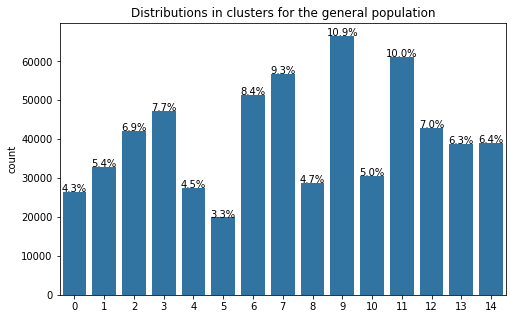

In [142]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#general population
base = sns.color_palette()[0]
total = len(labels)

fig = plt.figure(figsize = (8,5))
ax = sns.countplot(labels, color = base)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1%}'.format(height/total),
            ha="center") 
plt.title('Distributions in clusters for the general population')
plt.show();

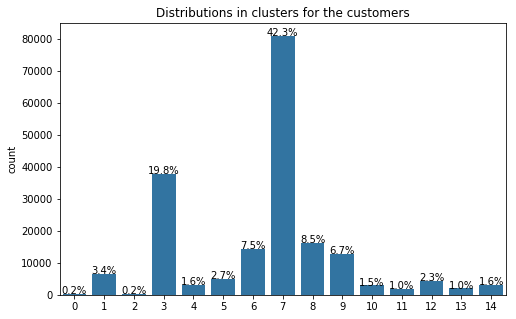

In [143]:
#clusters for customers
total_customers = len(customer_labels)

fig = plt.figure(figsize = (8,5))
ax_c = sns.countplot(customer_labels, color = base)

for p in ax_c.patches:
    height = p.get_height()
    ax_c.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1%}'.format(height/total_customers),
            ha="center") 
plt.title('Distributions in clusters for the customers')
plt.show();

In [144]:
df_cust_analysis = df_cust.copy()
df_cust_analysis['labels'] = customer_labels

In [145]:
df_cust_analysis.shape

(191652, 339)

In [146]:
df_cust_analysis['CUSTOMER_GROUP'] = df_merge_cust['CUSTOMER_GROUP']
df_cust_analysis['PRODUCT_GROUP'] = df_merge_cust['PRODUCT_GROUP']
df_cust_analysis['ONLINE_PURCHASE'] = df_merge_cust['ONLINE_PURCHASE']

In [147]:
df_cust_analysis=df_cust_analysis[['labels', 'CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE']]

In [148]:
df_cust_analysis.head()

,labels,CUSTOMER_GROUP,PRODUCT_GROUP,ONLINE_PURCHASE
0,7,MULTI_BUYER,COSMETIC_AND_FOOD,0
1,7,SINGLE_BUYER,FOOD,0
2,7,MULTI_BUYER,COSMETIC_AND_FOOD,0
3,6,MULTI_BUYER,COSMETIC,0
4,14,MULTI_BUYER,FOOD,0


In [149]:
df_cust_analysis.groupby(['ONLINE_PURCHASE', 'PRODUCT_GROUP']).count()

labels  CUSTOMER_GROUP
ONLINE_PURCHASE PRODUCT_GROUP                            
0               COSMETIC            38127           38127
                COSMETIC_AND_FOOD   92941           92941
                FOOD                43288           43288
1               COSMETIC             5283            5283
                COSMETIC_AND_FOOD    7919            7919
                FOOD                 4094            4094

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [171]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [172]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [173]:
LNR_resp = mailout_train[['LNR', 'RESPONSE']]

In [174]:
mailout_train_clean = clean_data_all(mailout_train)

In [175]:
mailout_train_clean.shape

(42962, 338)

In [176]:
mailout_train_clean.head()

,AKT_DAT_KL,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Mainstream,Decade,Wealth,LifeStage
0,1.0,0.0,13.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,...,2.0,6.0,9.0,3,2,4.0,1,40.0,3.0,4.0
1,4.0,0.0,1.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,...,1.0,4.0,9.0,1,2,3.0,1,70.0,3.0,2.0
2,1.0,0.0,1.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,1.0,NaN,9.0,3,1,4.0,0,40.0,1.0,4.0
3,1.0,0.0,4.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,...,2.0,6.0,9.0,3,2,4.0,0,40.0,1.0,4.0
4,1.0,0.0,44.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,...,1.0,6.0,9.0,3,1,3.0,1,50.0,4.0,1.0


In [177]:
Y = mailout_train_clean['RESPONSE']

In [178]:
mailout_train_clean = mailout_train_clean.drop('RESPONSE', axis=1)

In [179]:
Y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [180]:
532/42430

0.012538298373792129

Given the small proportion of customers with response = 1, we will optimize ROC-AUC rather than accuracy.
#### Feature Scaling ####

In [181]:
mailout_train_features = mailout_train_clean.copy()
mailout_train_features.shape

(42962, 337)

In [182]:
#imputing
imputed_mailout_train_features = imp.fit_transform(mailout_train_features)

#scaling
scaled_mailout_train_features = scaler.transform(imputed_mailout_train_features)

#pca
pca_mailout_train_features = pca.transform(scaled_mailout_train_features)

In [183]:
#clustering
mailout_train_labels = model.predict(pca_mailout_train_features)

In [187]:
pca_mailout_train_features.shape

(42962, 100)

In [188]:
X = pca_mailout_train_features

### Test different classifiers

In [189]:
def classifier_roc(clf, param_grid, X=X, y=Y):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    """
    
    start = time.time()
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc')
    grid.fit(X, y)
    
    end = time.time()
    print(end-start)

    print(grid.best_score_)
    
    return grid.best_estimator_

In [190]:
log_reg = LogisticRegression(random_state=0)
classifier_roc(log_reg, {})

8.168606519699097
0.589903725134


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [191]:
ada = AdaBoostClassifier()
classifier_roc(ada, {})

109.895667552948
0.549813976311


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [192]:
rf = RandomForestClassifier()
classifier_roc(rf, {})

28.879011869430542
0.50049352124


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [195]:
tree = DecisionTreeClassifier()
classifier_roc(tree, {})

76.86800956726074
0.493315554157


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [207]:
LogisticRegression().get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>

Logistic regression is the best-performing model for our problem so we will optimize that one. 

In [208]:
# Optimize Logistic Regression

start = time.time()

param_grid = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}

gridcv = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='roc_auc')
gridcv.fit(X, Y)
print(gridcv.best_score_)
print(gridcv.best_estimator_)

end = time.time()
print(end - start)

0.590737592313
LogisticRegression(C=0.61584821106602605, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
167.20260047912598


In [222]:
#final Clf
clf = LogisticRegression(solver='liblinear', penalty='l1', C=0.61584821106602605)

In [223]:
clf.fit(X,Y)

LogisticRegression(C=0.615848211066026, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### Results

We initially tried different ML algorithms and tested against ROC AUC. Using the default parameters we obtained the following ROC AUC results:
- Logistic Regression: 0.59
- AdaBoost Classifier: 0.55
- Random Forest Classifier: 0.50
- Decision Tree Classifier: 0.49

Logistic Regression performed better than AdaBoost here but it was also much faster so it was selected for fine tuning. 

We used the `liblinear` solver and tested against L1 and L2 penalties and different values for C (which measures the regularization strength and a smaller C corresponds to a stronger regularization. 

The best result was obtained with L1 penalty and C = 0.616 but it only improved ROC-AUC slightly (from 0.5899 to 0.5907). 

#### Test 

In [210]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [226]:
LNR = mailout_test['LNR']

In [211]:
mailout_test_clean = clean_data_all(mailout_test)

In [212]:
mailout_test_features = mailout_test_clean.copy()
mailout_test_features.shape

(42833, 337)

In [213]:
#imputing
imputed_mailout_test_features = imp.fit_transform(mailout_test_features)

#scaling
scaled_mailout_test_features = scaler.transform(imputed_mailout_test_features)

#pca
pca_mailout_test_features = pca.transform(scaled_mailout_test_features)

In [214]:
#clustering
mailout_test_labels = model.predict(pca_mailout_test_features)

In [215]:
X_test = pca_mailout_test_features

In [224]:
Y_test_est = clf.predict_proba(X_test)
Y_test_est

In [232]:
results = pd.concat([pd.DataFrame(LNR), pd.DataFrame(Y_test_est)], axis=1)
results = results[['LNR', 1]]

In [233]:
results.rename(columns = {1: 'RESPONSE'}, inplace=True)

In [239]:
results_csv = results.to_csv(r'results.csv', index = None, header=True) 

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### Conclusion
This project was aimed at maximising the success of a mailout campaign. To do that, we looked at various features of the general population and used PCA to apply an unsupervised learning model. Specifically we used KMeans and identified 15 clusters the population could be categorised in.

We then applied the same data preparation and clustering approach to the customers and the potential customers who could be part of the mailout campaign. 

For the latter, we used supervised learning to predict how likely they are of responding positively to the campaign. This is essential for the business as they could use a model like this one to design targeted campaigns and get higher response rates. 

I personally found the project interesting and would have loved to have more time to spend on it (unfortunately my deadline is coming up in a couple of days) to analyse the new features with the same attention as I analysed the ones for the project in term 1. I would have also tested with different algos and tuning to get better results. 

### Future Improvements 
In order to improve results, a few things could be done in the future:
- More time could be spent on feature engineering the new variables (as I had spent for the variables that were already present in term 1)
- Try more classifiers (XGBoost, Gradient Boosting Classifier, etc)
- Hyperparameter Tuning
- Try using a different number of PCA components and see if better results are obtained